# Feature Matching with SIFT
In this notebook we explore how we can use the [SIFT](https://www.researchgate.net/publication/235355151_Scale_Invariant_Feature_Transform) algorithm to create point correspondences between two images of the same static scene.
Erroneous correspondences may arise due to imperfect feature descriptors, but we can surpress these outliers using [RANSAC](https://www.sciencedirect.com/science/article/pii/B9780080515816500702).

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# To display images within Jupyter.
%matplotlib inline

# Load and plot source and target images.
img_dir = os.path.join(os.getcwd(), "sift_images")

# Load images
img1 = cv2.imread(os.path.join(img_dir, "staple.jpg"), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(img_dir, "scene.jpg"), cv2.IMREAD_GRAYSCALE)

First, lets take a look at the two images of the scene:

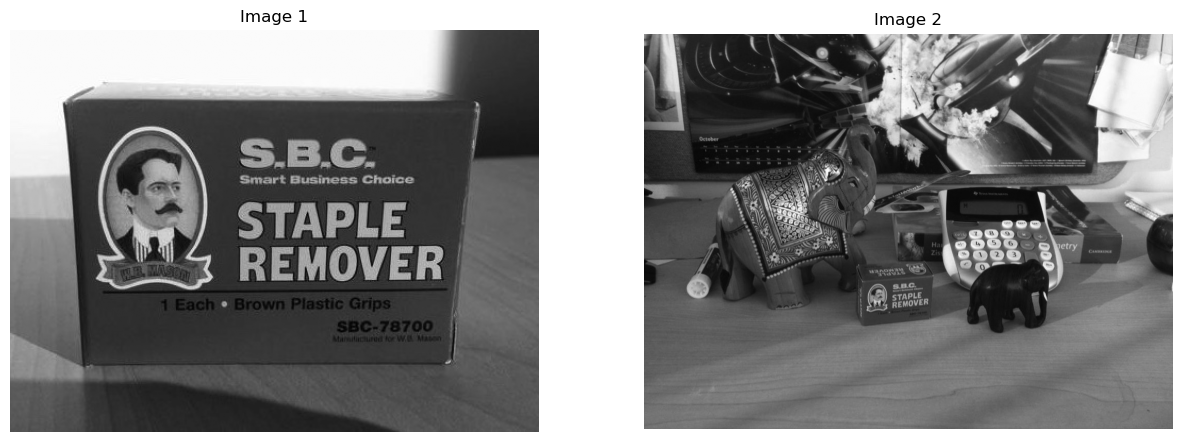

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Image 1')
axes[0].set_axis_off()
axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Image 2')
axes[1].set_axis_off()
plt.show()

### SIFT Feature Detection
Now, we can run the code below to use the SIFT algorithm to detect features in the two images separately:

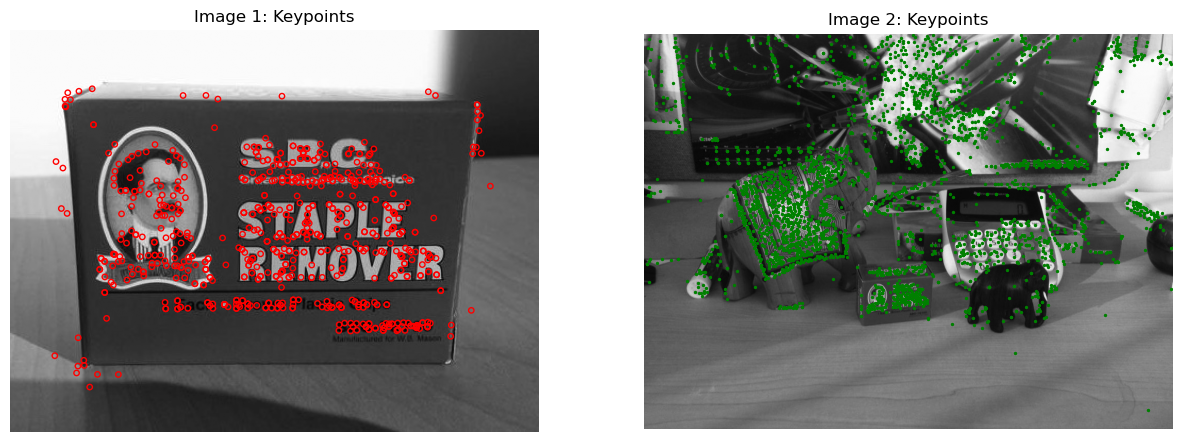

In [3]:
# Initialize the SIFT detector.
sift = cv2.SIFT_create()

# Detect keypoints and extract their descriptors.
img1_keypoints, img1_descriptors = sift.detectAndCompute(img1, None)
img2_keypoints, img2_descriptors = sift.detectAndCompute(img2, None)

# Extract keypoints to numpy arrays.
img1_pts = np.array([kp.pt for kp in img1_keypoints])
img2_pts = np.array([kp.pt for kp in img2_keypoints])

fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
axes[0].imshow(img1, cmap='gray')
axes[0].scatter(img1_pts[:, 0], img1_pts[:, 1], color='red', s=15, facecolor='none', marker='o')
axes[0].set_title('Image 1: Keypoints')
axes[0].set_axis_off()
axes[1].imshow(img2, cmap='gray')
axes[1].scatter(img2_pts[:, 0], img2_pts[:, 1], color='green', s=2)
axes[1].set_title('Image 2: Keypoints')
axes[1].set_axis_off()
plt.show()

### Match ORB Features Across Images

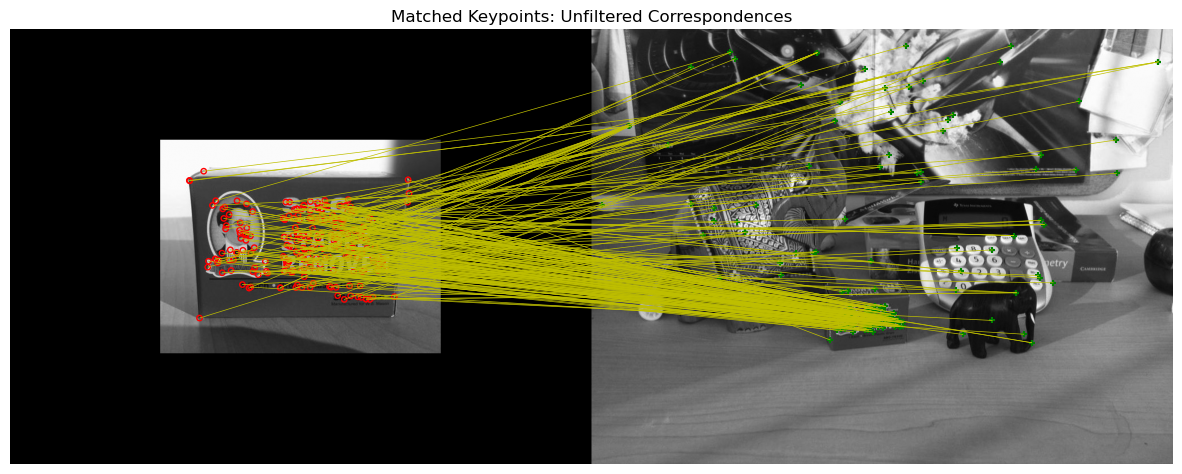

In [4]:
# Create BFMatcher (Brute Force Matcher) object with L2 norm (which is suitable for SIFT).
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors and threshold based on L2 norm.
raw_matches = bf.knnMatch(img1_descriptors, img2_descriptors, k=2)

# Apply ratio test to retain good matches.
# NOTE: try 0.5, or 0.75 as threshold values!
threshold = 0.9 
strong_matches = [m for m, n in raw_matches if m.distance < threshold * n.distance]

# Extract keypoints to numpy arrays.
img1_pts_matched_unfiltered = np.array([img1_keypoints[m.queryIdx].pt for m in strong_matches])
img2_pts_matched_unfiltered = np.array([img2_keypoints[m.trainIdx].pt for m in strong_matches])

# Apply zero padding to the source image.
h_diff = img2.shape[0] - img1.shape[0]
w_diff = img2.shape[1] - img1.shape[1]
top, left = h_diff // 2, w_diff // 2
bottom, right = h_diff - top, w_diff - left
img1_padded = cv2.copyMakeBorder(img1, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

# Horizontally concatenate the images and shift matched points accordingly.
concat_img = np.hstack((img1_padded, img2))
img1_pts_plot = img1_pts_matched_unfiltered + np.array([left, top])
img2_pts_plot = img2_pts_matched_unfiltered + np.array([img1_padded.shape[1], 0])

# Display the concatenated image.
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.imshow(concat_img, cmap='gray')
ax.set_title('Matched Keypoints: Unfiltered Correspondences')
ax.set_axis_off()

# Plot lines between matched keypoints.
for i in range(len(img1_pts_plot)):
    ax.plot(
        [img1_pts_plot[i][0], img2_pts_plot[i][0]], 
        [img1_pts_plot[i][1], img2_pts_plot[i][1]], 
        'y-', linewidth=0.5
    )
    
    # Plot starting point with a red "o".
    ax.scatter(
        img1_pts_plot[i][0], 
        img1_pts_plot[i][1], 
        color='red', 
        s=15, 
        facecolor='none', 
        marker='o'
    )
    
    # Plot ending point with a green "+".
    ax.scatter(
        img2_pts_plot[i][0], 
        img2_pts_plot[i][1], 
        color='green', 
        s=15, 
        marker='+'
    )
plt.show()

### Remove Outlier Feature Matches
Now we can use the RANSAC algorithm to find a good subset of the raw features matches to remove outliers.

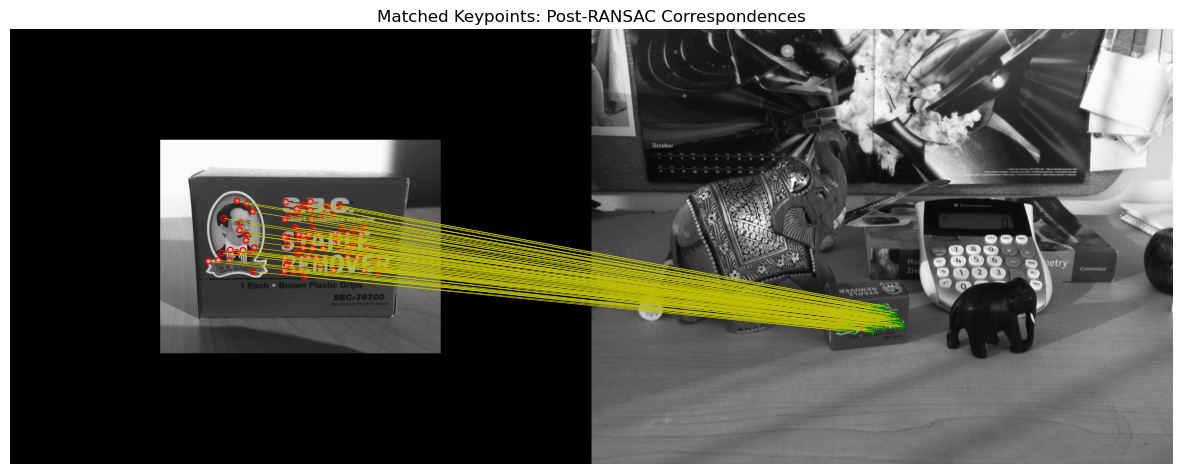

In [5]:
# Use the RANSAC algorithm to find a good subset of feature matches.
homography, inliers = cv2.findHomography(
    img1_pts_matched_unfiltered, 
    img2_pts_matched_unfiltered, 
    cv2.RANSAC, 
    5.0
)
matches_mask = inliers.squeeze().astype(bool)

# Horizontally concatenate the images and shift matched points accordingly.
img1_pts_plot = img1_pts_matched_unfiltered[matches_mask] + np.array([left, top])
img2_pts_plot = img2_pts_matched_unfiltered[matches_mask] + np.array([img1_padded.shape[1], 0])

# Display the concatenated image.
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.imshow(concat_img, cmap='gray')
ax.set_title('Matched Keypoints: Post-RANSAC Correspondences')
ax.set_axis_off()

# Plot lines between matched keypoints.
for i in range(len(img1_pts_plot)):
    ax.plot(
        [img1_pts_plot[i][0], img2_pts_plot[i][0]], 
        [img1_pts_plot[i][1], img2_pts_plot[i][1]], 
        'y-', linewidth=0.5
    )
    
    # Plot starting point with a red "o".
    ax.scatter(
        img1_pts_plot[i][0], 
        img1_pts_plot[i][1], 
        color='red', 
        s=15, 
        facecolor='none', 
        marker='o'
    )
    
    # Plot ending point with a green "+".
    ax.scatter(
        img2_pts_plot[i][0], 
        img2_pts_plot[i][1], 
        color='green', 
        s=15, 
        marker='+'
    )
plt.show()